# <center> Final project</center>

## Introduction

In this project, you are going to work with the dataset based on the census data extracted from the 1994 and 1995 current population surveys conducted by the U.S. Census Bureau. Your goal is to predict level of income of a person: "- 50000" (means less than \$50k/year) or "50000+" (means more than \$50k/year). The data is split into train (`train.csv`) and test (`test.csv`) parts. You should use train part to train the models, and test part to estimate their final quality. The best quality on the test dataset should be your final result.

The description of the data is available here: https://archive.ics.uci.edu/ml/datasets/Census-Income+%28KDD%29

_Citation:_

* _Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science._

## Detailed Task Description

The solution should have the following parts:

### 1. Data exploration

* 1.1. Which metric are you going to use to evaluate the performance of the model and why?
* 1.2. Which validation strategy are you going to use and why? Apply it to the data on the preprocessing step
* 1.3. Explore which features do you have, what is their distribution and connection to the target. Perform feature selection techniques such as PCA, and feature engineering, if necessary. Explain your decisions

### 2. Data preprocessing

* 2.1. Fill missing values (if there are any)
* 2.2. Properly encode categorical features. Explain your choice of methods of categorical feature encoding
* 2.3. Cluster observations and add cluster number as one of the features. Make sure that the clustering method has a good quality

### 3. Model training

* 3.1. Apply different techniques which can help to work with imbalanced data. You are supposed to try at least 2 techniques (in the end, you don't have to include them into your final pipeline - but you should explain why)
* 3.2. Train different machine learning models, including the advanced boosting algorithms studied during the course. Carefully tune hyperparameters of the algorithms. You are supposed to compare at least 3 models
* 3.3. Perform blending or stacking of the trained machine learning algorithms. Carefully tune the weights of the ensemble

### 4. Summary

* 4.1. Estimate the quality of the models and their ensemble on the test set. Describe the results. Which model is the best?
* 4.2. Interpret the best single model and the ensemble. Use at least 2 model interpretation techniques. Explain, why your models have good quality (or bad quality)
* 4.3. Summarize your results and write a conclusion. What have you found in the data, which techniques did you use? Which methods and models worked best in your task? Can you explain in simple words why should we trust your final model?

### General Requirements

* You should provide a solution in the form of the Jupyter Notebook with code cells and markdown cells (with text)
* Make sure that the instructor can run all the cells to reproduce your results
* Clearly answer each question, perform the required actions from the task. Explain your decisions if you choose to use some techniques
* Support all your statements with calculations and plots. For instance, if you claim that the dataset does not have missing values, you need to provide the code which shows that the total number of missing values is zero

# Solution

## 1. Data exploration

1.1. The goal of the task is to predict the level of income of a person: lower or greater than \$50k.
The task by its core might be interpreted as binary classification, when it is neccessary to predict whether the target value from positive (>\$50k) or negative (<\$50k) class.
There are many metrics that can be used to measure the performance of a binary classifier. We have not seen data yet, and can assume that such metrics as precision and recall (or their harmonic mean f1-score in case the samples are imbalanced across target classes) might be used to evaluate the performance of the model.
We will decide that model is good enough if F1-score is greater than 0.85.


1.2. There are many validation strategies to estimate a model performance from the simple train/test split to rather complex approaches like nested cross-validation. First we will split our data on train and test datasets (it has actually been done since our initial dataset consists of `census-income.data` and `census-income.test` files) and then train dataset will be split again into train and validation parts with k-fold stratification (in case the samples are imbalanced across target classes). Necessary to notice that train/validation split will be performed inside `cross_val_score` function [link](https://scikit-learn.org/stable/modules/cross_validation.html)

1.3. Features exploration

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
import warnings
warnings.filterwarnings("ignore")

Name of the attributes (features) are taken from `census-income.names` file.

Note from the `census-income.names` file: "The instance weight indicates the number of people in the population that each record represents due to stratified sampling. This attribute should *not* be used in the classifiers."
Moreover, feature `year` tells about the year of census, and obviously redundant for our task.
Therefore, we will drop these features (`instance_weight`, `year`) from training dataset and test dataset as well.

In [6]:
features = [
    'age',
    'class_of_worker',
    'detailed_industry_recode',
    'detailed_occupation_recode',
    'education',
    'wage_per_hour',
    'enroll_in_edu_inst_last_wk',
    'marital_stat',
    'major_industry_code',
    'major_occupation_code',
    'race',
    'hispanic_origin',
    'sex',
    'member_of_a_labor_union',
    'reason_for_unemployment',
    'full_or_part_time_employment_stat',
    'capital_gains',
    'capital_losses',
    'dividends_from_stocks',
    'tax_filer_stat',
    'region_of_previous_residence',
    'state_of_previous_residence',
    'detailed_household_and_family_stat',
    'detailed_household_summary_in_household',
    'instance_weight',
    'migration_code-change_in_msa',
    'migration_code-change_in_reg',
    'migration_code-move_within_reg',
    'live_in_this_house_1_year_ago',
    'migration_prev_res_in_sunbelt',
    'num_persons_worked_for_employer',
    'family_members_under_18',
    'country_of_birth_father',
    'country_of_birth_mother',
    'country_of_birth_self',
    'citizenship',
    'own_business_or_self_employed',
    'fill_in_questionnaire_for_veteran_admin',
    "veterans_benefits",
    'weeks_worked_in_year',
    'year',
    'target'
]

In [7]:
columns_to_drop = ['instance_weight', 'year']

In [13]:
# path_common = '/content/drive/MyDrive/Data_FP_AML/'
path_common = './data/'

Let us read train data and substitute " ?" by NaN.

In [14]:
data = pd.read_csv(path_common + 'census-income.data', names=features, na_values=' ?')
data.head()

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_in_questionnaire_for_veteran_admin,veterans_benefits,weeks_worked_in_year,year,target
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


**Brief data observation**

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   age                                      199523 non-null  int64  
 1   class_of_worker                          199523 non-null  object 
 2   detailed_industry_recode                 199523 non-null  int64  
 3   detailed_occupation_recode               199523 non-null  int64  
 4   education                                199523 non-null  object 
 5   wage_per_hour                            199523 non-null  int64  
 6   enroll_in_edu_inst_last_wk               199523 non-null  object 
 7   marital_stat                             199523 non-null  object 
 8   major_industry_code                      199523 non-null  object 
 9   major_occupation_code                    199523 non-null  object 
 10  race                            

There are 41 different features (columns) of three types (float64, int64, object) in the dataset.

Let us find fully identical rows in the training data.

Find duplicates among all objects (rows) and features (except target value). If for example we find duplicates and their target values are different, such rows will definately confuse our model and probably decrease its generalizing ability.

In [16]:
duplicated_rows = data[data.columns[:-1]].duplicated()
any_duplicates = duplicated_rows.any()
if any_duplicates:
  print('Number of duplicated rows:', data[duplicated_rows].shape[0] )
  print('Duplicated Rows:')
  display(data[duplicated_rows][:3])
else:
  print('There are not any duplicates')

Number of duplicated rows: 3230
Duplicated Rows:


,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_in_questionnaire_for_veteran_admin,veterans_benefits,weeks_worked_in_year,year,target
2784,11,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4967,4,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.
5175,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


So, there are 3230 identical rows. Let us check their targets.

In [17]:
data[duplicated_rows]['target'].unique()

array([' - 50000.'], dtype=object)

Luckily, all the targets equal ' - 50000.'.

Thus, duplicated rows are not conflicting against target value. We will keep this observation in mind, just in case.

### **Explore categorical features**

Info regarding of categorical features


In [18]:
data.describe(include=['O'])

,class_of_worker,education,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,...,migration_code-move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,fill_in_questionnaire_for_veteran_admin,target
count,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,...,99827,199523,99827,199523,192810,193404,196130,199523,199523,199523
unique,9,17,3,7,24,15,5,10,2,3,...,9,3,3,5,42,42,42,5,3,2
top,Not in universe,High school graduate,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,...,Nonmover,Not in universe under 1 year old,Not in universe,Not in universe,United-States,United-States,United-States,Native- Born in the United States,Not in universe,- 50000.
freq,100245,48407,186943,86485,100684,100684,167365,171907,103984,180459,...,82538,101212,84054,144232,159163,160479,176989,176992,197539,187141


Initially there are 29 categorical features, highly likely that some of them are binary (e.g. sex), others ordinal (e.g. education) or nominal ones.
Let us examine the following features which seem to be valuable (according to their names) in more detail:
- education;
- marital_stat;
- race;
- hispanic_origin;
- sex;
- detailed_household_summary_in_household;
- citizenship;
- target.

Support function `draw_plot` is used to draw a bar plot or a histogram where needed.

In [19]:
def draw_plot(feature: pd.Series, proportion=True, x_rotation=0, ax=None):

    '''
    Draw a bar plot or histogram
    '''

    plt.figure(figsize=(5, 3))
    if proportion:
        feature.value_counts(normalize=True, ascending=True).apply(lambda x: round(x * 100, 1)).plot(kind='bar',
                                edgecolor='black',
                                zorder=2, ax=ax)
        plt.xlabel(f'{feature.name}')
        plt.ylabel('Proportion, %')
        plt.xticks(rotation=x_rotation)
        plt.grid(zorder=0)
        plt.title(f"Distribution of the '{feature.name}' variable")
        return f"Proportion of classes in '{feature.name}', %:\n{feature.value_counts(normalize=True).apply(lambda x: round(x * 100, 1))}"
    else:
        feature.plot(kind='hist',
                     edgecolor='black',
                     zorder=2)
    plt.xticks(rotation=x_rotation)
    plt.grid(zorder=0)
    plt.title(f"Distribution of the '{feature.name}' variable")
    plt.show()

Explore `education`

Support function `draw_countplot` is used to draw a countplot where needed.

In [20]:
def draw_countplot(feature, sort=True, h=True):

  '''
  Draw a countplot
  '''
  if sort:
    if h:
      plt.figure(figsize=(3, 5))
      sns.countplot(data=data, y=feature.name, hue='target', palette="Set2", edgecolor='black', zorder=2, order = feature.value_counts().sort_values().index);
      plt.xticks(rotation=0)
    else:
      plt.figure(figsize=(5, 3))
      sns.countplot(data=data, x=feature.name, hue='target', palette="Set2", edgecolor='black', zorder=2, order = feature.value_counts().sort_values().index);
      plt.xticks(rotation=90)
  else:
    if h:
      plt.figure(figsize=(3, 5))
      sns.countplot(data=data, y=feature.name, hue='target',  bins=25,  palette="Set2", edgecolor='black', zorder=2);
      plt.xticks(rotation=0)
    else:
      plt.figure(figsize=(5, 3))
      sns.countplot(data=data, x=feature.name, hue='target',  bins=25,  palette="Set2", edgecolor='black', zorder=2);
      plt.xticks(rotation=90)
  plt.grid(zorder=0)
  plt.title(f"Connection of the '{feature.name}' with the target variable");

Proportion of classes in 'education', %:
 High school graduate                      24.3
 Children                                  23.8
 Some college but no degree                13.9
 Bachelors degree(BA AB BS)                10.0
 7th and 8th grade                          4.0
 10th grade                                 3.8
 11th grade                                 3.4
 Masters degree(MA MS MEng MEd MSW MBA)     3.3
 9th grade                                  3.1
 Associates degree-occup /vocational        2.7
 Associates degree-academic program         2.2
 5th or 6th grade                           1.6
 12th grade no diploma                      1.1
 1st 2nd 3rd or 4th grade                   0.9
 Prof school degree (MD DDS DVM LLB JD)     0.9
 Doctorate degree(PhD EdD)                  0.6
 Less than 1st grade                        0.4
Name: education, dtype: float64


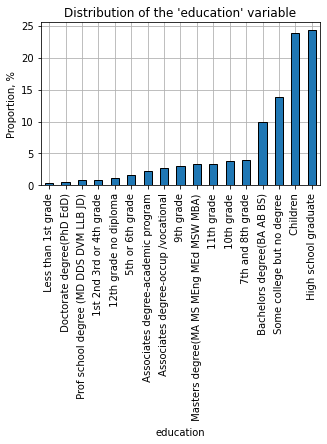

In [21]:
feature = 'education'
print(draw_plot(data[feature], x_rotation=90))

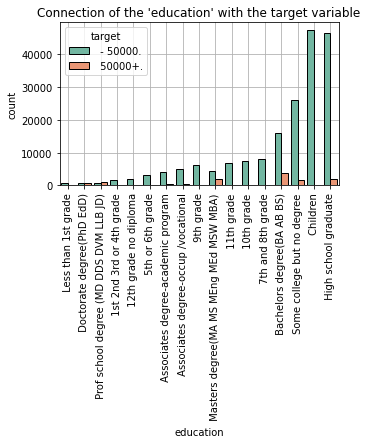

In [22]:
draw_countplot(data[feature], h=False)

We can see that level of income (target) depends on the level education. People with `Doctorate degree(PhD EdD)`, `Prof school degree (MD DDS DVM LLB JD)` and `Masters degree(MA MS MEng MEd MSW MBA)` have relatively higher income than people with other levels of education (e.g. `Less than 1st grade`: only 0.1% has high income, 99.9% of others have income lower than \$50k (calculations below).

In [23]:
# Proportion (%) of people in each educational level by income
(data.groupby(by=[feature, 'target'])[['target']].count()/data.groupby(by=[feature])[['target']].count()).apply(lambda x: 100*round(x, 3))

target
education                               target           
 10th grade                              - 50000.    99.2
                                         50000+.      0.8
 11th grade                              - 50000.    99.0
                                         50000+.      1.0
 12th grade no diploma                   - 50000.    98.4
                                         50000+.      1.6
 1st 2nd 3rd or 4th grade                - 50000.    99.3
                                         50000+.      0.7
 5th or 6th grade                        - 50000.    99.3
                                         50000+.      0.7
 7th and 8th grade                       - 50000.    99.1
                                         50000+.      0.9
 9th grade                               - 50000.    99.4
                                         50000+.      0.6
 Associates degree-academic program      - 50000.    90.6
                                         50000+.      9.4
 Associates degree-occup /vocational     - 50000.    92.3
                                         50000+.      7.7
 Bachelors degree(BA AB BS)              - 50000.    80.3
                                         50000+.     19.7
 Children                                - 50000.   100.0
 Doctorate degree(PhD EdD)               - 50000.    48.0
                                         50000+.     52.0
 High school graduate                    - 50000.    96.1
                                         50000+.      3.9
 Less than 1st grade                     - 50000.    99.9
                                         50000+.      0.1
 Masters degree(MA MS MEng MEd MSW MBA)  - 50000.    68.8
                                         50000+.     31.2
 Prof school degree (MD DDS DVM LLB JD)  - 50000.    46.0
                                         50000+.     54.0
 Some college but no degree              - 50000.    93.6
                                         50000+.      6.4

Explore `marital_stat`


Proportion of classes in 'marital_stat', %:
 Never married                      43.3
 Married-civilian spouse present    42.2
 Divorced                            6.4
 Widowed                             5.2
 Separated                           1.7
 Married-spouse absent               0.8
 Married-A F spouse present          0.3
Name: marital_stat, dtype: float64


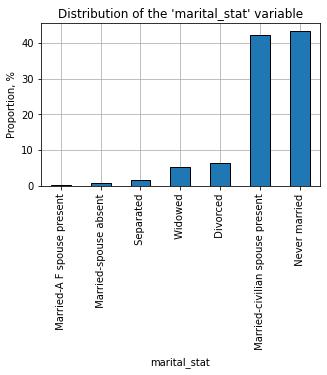

In [24]:
feature = 'marital_stat'
print(draw_plot(data[feature], x_rotation=90))

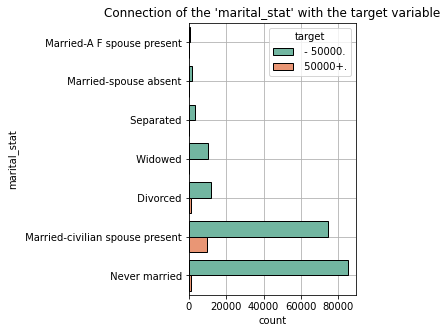

In [25]:
draw_countplot(data[feature])

In [26]:
# Proportion (%) of people in each category by income
(data.groupby(by=[feature, 'target'])[['target']].count()/data.groupby(by=[feature])[['target']].count()).apply(lambda x: 100*round(x, 3))

target
marital_stat                     target           
 Divorced                         - 50000.    91.6
                                  50000+.      8.4
 Married-A F spouse present       - 50000.    97.7
                                  50000+.      2.3
 Married-civilian spouse present  - 50000.    88.6
                                  50000+.     11.4
 Married-spouse absent            - 50000.    93.7
                                  50000+.      6.3
 Never married                    - 50000.    98.7
                                  50000+.      1.3
 Separated                        - 50000.    95.4
                                  50000+.      4.6
 Widowed                          - 50000.    96.8
                                  50000+.      3.2

`marital_stat` does not have a vivid correlation with income. In each category the majority of people (~90%) earn less than $50k.

Explore `race`

Proportion of classes in 'race', %:
 White                          83.9
 Black                          10.2
 Asian or Pacific Islander       2.9
 Other                           1.8
 Amer Indian Aleut or Eskimo     1.1
Name: race, dtype: float64


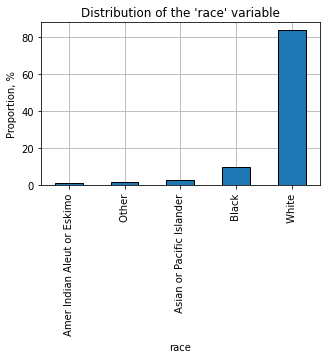

In [27]:
feature = 'race'
print(draw_plot(data[feature], x_rotation=90))

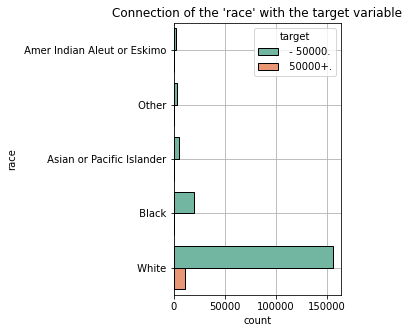

In [28]:
draw_countplot(data[feature])

In [29]:
# Proportion (%) of people in each category by income
data.groupby(by=[feature, 'target'])[['target']].count()/data.groupby(by=[feature])[['target']].count()

target
race                         target             
 Amer Indian Aleut or Eskimo  - 50000.  0.978232
                              50000+.   0.021768
 Asian or Pacific Islander    - 50000.  0.926307
                              50000+.   0.073693
 Black                        - 50000.  0.973549
                              50000+.   0.026451
 Other                        - 50000.  0.975116
                              50000+.   0.024884
 White                        - 50000.  0.932650
                              50000+.   0.067350

Representatives of `White` and `Asian or Pacific Islander` categories have relatively high income, if compare with other categories.

Explore `hispanic_origin`

Proportion of classes in 'hispanic_origin', %:
 All other                    86.2
 Mexican-American              4.0
 Mexican (Mexicano)            3.6
 Central or South American     2.0
 Puerto Rican                  1.7
 Other Spanish                 1.2
 Cuban                         0.6
 NA                            0.4
 Do not know                   0.2
 Chicano                       0.2
Name: hispanic_origin, dtype: float64


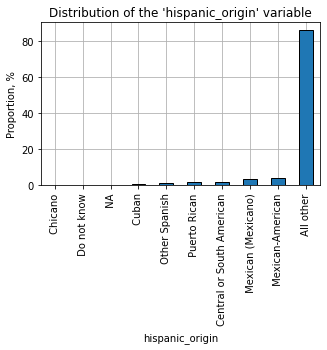

In [30]:
feature = 'hispanic_origin'
print(draw_plot(data[feature], x_rotation=90))

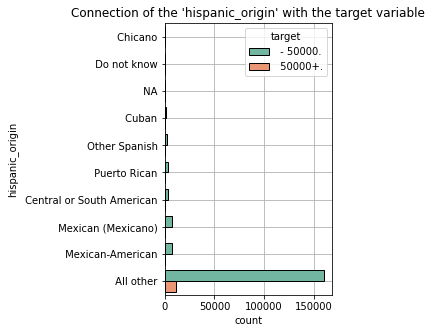

In [31]:
draw_countplot(data[feature])

In [32]:
# Proportion (%) of people in each category by income
(data.groupby(by=[feature, 'target'])[['target']].count()/data.groupby(by=[feature])[['target']].count()).apply(lambda x: 100*round(x, 3))


target
hispanic_origin            target           
 All other                  - 50000.    93.2
                            50000+.      6.8
 Central or South American  - 50000.    97.9
                            50000+.      2.1
 Chicano                    - 50000.    98.0
                            50000+.      2.0
 Cuban                      - 50000.    94.6
                            50000+.      5.4
 Do not know                - 50000.    97.4
                            50000+.      2.6
 Mexican (Mexicano)         - 50000.    98.9
                            50000+.      1.1
 Mexican-American           - 50000.    97.9
                            50000+.      2.1
 NA                         - 50000.    93.5
                            50000+.      6.5
 Other Spanish              - 50000.    96.7
                            50000+.      3.3
 Puerto Rican               - 50000.    97.9
                            50000+.      2.1

Not as much additional info we can take from `hispanic_origin`.

Taking into account graphs and tables above, we may conclude that `hispanic_origin` feature highly unlikely containes any useful information for our task.
Short excert from the training dataset proves our assumption (see DataFrame below).

Thus, `hispanic_origin` will be dropped.

In [33]:
data[['race','hispanic_origin', 'country_of_birth_self']][100:125]

,race,hispanic_origin,country_of_birth_self
100,White,All other,United-States
101,White,All other,United-States
102,White,All other,United-States
103,White,Mexican-American,United-States
104,White,All other,United-States
105,White,Mexican-American,United-States
106,White,All other,United-States
107,White,All other,United-States
108,White,Mexican (Mexicano),Mexico
109,White,All other,United-States


In [34]:
columns_to_drop.extend(['hispanic_origin'])

Explore `sex`

Proportion of classes in 'sex', %:
 Female    52.1
 Male      47.9
Name: sex, dtype: float64


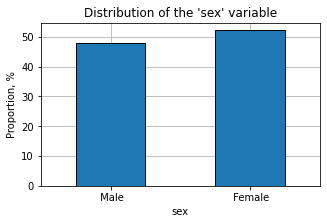

In [35]:
feature = 'sex'
print(draw_plot(data[feature], x_rotation=0))

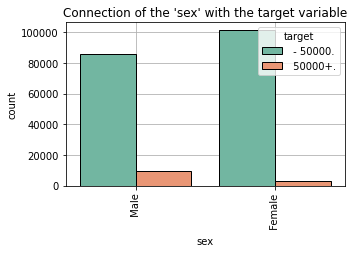

In [36]:
draw_countplot(data[feature], h=False)

In [37]:
# Proportion (%) of people in each category by income
(data.groupby(by=[feature, 'target'])[['target']].count()/data.groupby(by=[feature])[['target']].count()).apply(lambda x: 100*round(x, 3))

target
sex     target           
 Female  - 50000.    97.4
         50000+.      2.6
 Male    - 50000.    89.8
         50000+.     10.2

Feature `sex` seems to be important, since 10.2% of men have high income and only 2.6% of women have as well.

Explore `detailed_household_summary_in_household`

Proportion of classes in 'detailed_household_summary_in_household', %:
 Householder                             37.8
 Child under 18 never married            25.3
 Spouse of householder                   20.9
 Child 18 or older                        7.2
 Other relative of householder            4.9
 Nonrelative of householder               3.8
 Group Quarters- Secondary individual     0.1
 Child under 18 ever married              0.0
Name: detailed_household_summary_in_household, dtype: float64


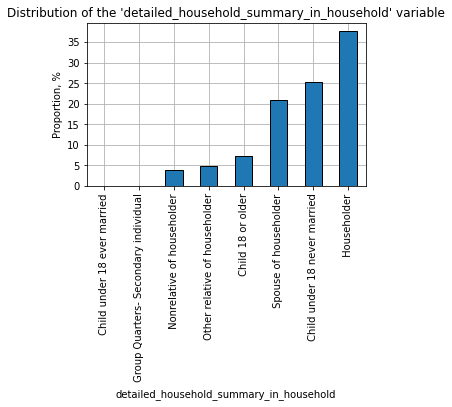

In [38]:
feature = 'detailed_household_summary_in_household'
print(draw_plot(data[feature], x_rotation=90))

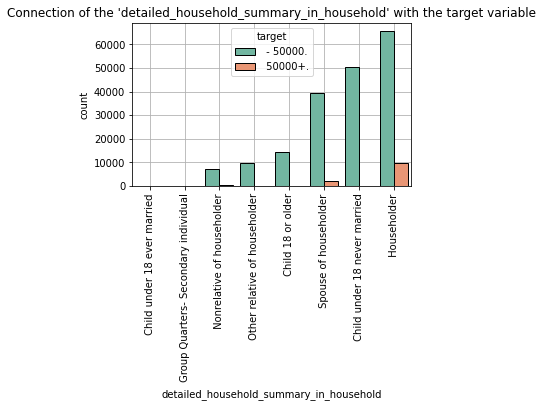

In [39]:
draw_countplot(data[feature], h=False)

In [40]:
# Proportion (%) of people in each category by income
(data.groupby(by=[feature, 'target'])[['target']].count()/data.groupby(by=[feature])[['target']].count()).apply(lambda x: 100*round(x, 3))

target
detailed_household_summary_in_household target           
 Child 18 or older                       - 50000.    99.1
                                         50000+.      0.9
 Child under 18 ever married             - 50000.   100.0
 Child under 18 never married            - 50000.   100.0
                                         50000+.      0.0
 Group Quarters- Secondary individual    - 50000.    99.2
                                         50000+.      0.8
 Householder                             - 50000.    87.2
                                         50000+.     12.8
 Nonrelative of householder              - 50000.    96.9
                                         50000+.      3.1
 Other relative of householder           - 50000.    99.1
                                         50000+.      0.9
 Spouse of householder                   - 50000.    94.5
                                         50000+.      5.5

So, if a person belongs to a category `Householder` or `Spouse of householder`, he (or she) will relatively often have higher income.

Explore `citizenship`

In [41]:
feature = 'citizenship'

Proportion of classes in 'citizenship', %:
 Native- Born in the United States              88.7
 Foreign born- Not a citizen of U S              6.7
 Foreign born- U S citizen by naturalization     2.9
 Native- Born abroad of American Parent(s)       0.9
 Native- Born in Puerto Rico or U S Outlying     0.8
Name: citizenship, dtype: float64


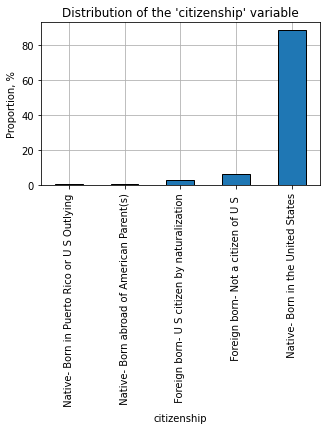

In [42]:
print(draw_plot(data[feature], x_rotation=90))

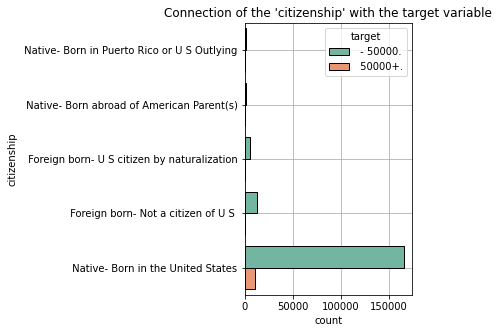

In [43]:
draw_countplot(data[feature])

In [44]:
# Proportion (%) of people in each category by income
(data.groupby(by=[feature, 'target'])[['target']].count()/data.groupby(by=[feature])[['target']].count()).apply(lambda x: 100*round(x, 3))

target
citizenship                                  target           
 Foreign born- Not a citizen of U S           - 50000.    96.3
                                              50000+.      3.7
 Foreign born- U S citizen by naturalization  - 50000.    90.1
                                              50000+.      9.9
 Native- Born abroad of American Parent(s)    - 50000.    92.7
                                              50000+.      7.3
 Native- Born in Puerto Rico or U S Outlying  - 50000.    97.8
                                              50000+.      2.2
 Native- Born in the United States            - 50000.    93.7
                                              50000+.      6.3

In accordance with the DataFrame above: native US citizen (of any kind) is more likely to have higher income.

In [45]:
feature = 'reason_for_unemployment'

Proportion of classes in 'reason_for_unemployment', %:
 Not in universe          97.0
 Other job loser           1.0
 Re-entrant                1.0
 Job loser - on layoff     0.5
 Job leaver                0.3
 New entrant               0.2
Name: reason_for_unemployment, dtype: float64


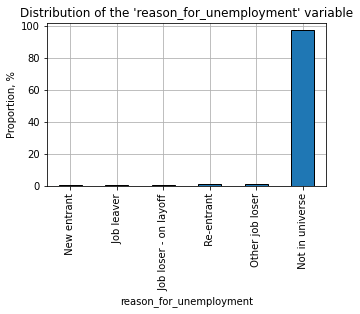

In [46]:
print(draw_plot(data[feature], x_rotation=90))

We can see that 97% of values are Not in universe (Not applicable), so this feature does not imply any impact on the target prediction since the only one category is dominant. We will drop `reason_for_unemployment`.

In [47]:
columns_to_drop.append('reason_for_unemployment')

Explore `target`: level of income.

To begin with, let us draw the barplot for the target variable as a proportion between classes.

Proportion of classes in 'target', %:
 - 50000.    93.8
 50000+.      6.2
Name: target, dtype: float64


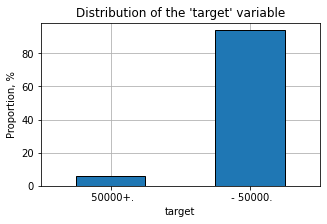

In [48]:
feature = 'target'
print(draw_plot(data[feature], proportion=True))

We found out that the sample target classes are highly imbalanced:
- negative class (income < \$50k) is 93.8% of all observations;
- positive class (income > \$50k) is 6.2% of all observations.

Thus, highly likely we will use f1-score as a metric for a model performance evaluation.

In [49]:
print('Type of target variable:', data['target'].dtypes)

Type of target variable: object


Since we proved that target variable is binary (takes only two possible values) let us turn it into integer type values (zeros and ones): negative class ( - 50000.) becomes zero, positive class ( 50000+.) becomes one.

In [50]:
target_map = {' - 50000.': 0, ' 50000+.': 1}
data['target'] = data['target'].map(target_map)
assert data['target'].dtypes == 'int64'

In [51]:
# creata a map dictionary to save all the mappings we will create, since later we will apply the same mapping to the test data.
# structure of the dictionary
# map = {'feature': feature_map }

map = {'target': target_map}

### **Feature engineering**

Features `migration_code-change_in_msa`, `migration_code-move_within_reg`, `migration_code-change_in_reg`, `migration_prev_res_in_sunbelt` could be converted into one more general feature named `migration_code` by the following procedure:
- find the categories with the same names inside features

In [52]:
migration_columns = [column for column in data.columns if column.startswith('migration_code')]
migration_columns

['migration_code-change_in_msa',
 'migration_code-change_in_reg',
 'migration_code-move_within_reg']

In [53]:
for column in migration_columns:
  print(f"Feature '{column}' has the following unique values:")
  print(*data[column].unique(), sep=',', end='.\n\n')

Feature 'migration_code-change_in_msa' has the following unique values:
nan, MSA to MSA, Nonmover, NonMSA to nonMSA, Not in universe, Not identifiable, Abroad to MSA, MSA to nonMSA, Abroad to nonMSA, NonMSA to MSA.

Feature 'migration_code-change_in_reg' has the following unique values:
nan, Same county, Nonmover, Different region, Different county same state, Not in universe, Different division same region, Abroad, Different state same division.

Feature 'migration_code-move_within_reg' has the following unique values:
nan, Same county, Nonmover, Different state in South, Different county same state, Not in universe, Different state in Northeast, Abroad, Different state in Midwest, Different state in West.



In [54]:
migration_map = {
    ' MSA to MSA': 'Other',
    ' MSA to nonMSA': 'Other',
    ' NonMSA to MSA':  'Other',
    ' NonMSA to nonMSA': 'Other',
    ' Not identifiable': 'Not in universe',
    ' Not in universe': 'Not in universe',
    ' Abroad to MSA': 'Abroad',
    ' Abroad to nonMSA': 'Abroad',
    ' Nonmover': 'Nonmover',
    ' Same county': 'Other',
    ' Different region': 'Other',
    ' Different county same state': 'Other',
    ' Different division same region': 'Other',
    ' Different state same division': 'Other',
    ' Abroad': 'Abroad',
    ' Different state in South': 'Other',
    ' Different state in Northeast': 'Other',
    ' Different state in Midwest': 'Other',
    ' Different state in West': 'Other'
}
# save mapping into dict map
map['migration_code-change_in_msa'] = migration_map


Let us apply mapping to the features above.

In [55]:
feature = 'migration_code-change_in_msa'
print('feature:', feature)
print('Unique values BEFORE mapping\n', data[feature].unique(), '\nNumber of NaNs', data[feature].isna().sum())
data[feature] = data[feature].map(migration_map)
print('Unique values AFTER mapping', data[feature].unique(), '\nNumber of NaNs', data[feature].isna().sum())

feature: migration_code-change_in_msa
Unique values BEFORE mapping
 [nan ' MSA to MSA' ' Nonmover' ' NonMSA to nonMSA' ' Not in universe'
 ' Not identifiable' ' Abroad to MSA' ' MSA to nonMSA' ' Abroad to nonMSA'
 ' NonMSA to MSA'] 
Number of NaNs 99696
Unique values AFTER mapping [nan 'Other' 'Nonmover' 'Not in universe' 'Abroad'] 
Number of NaNs 99696


In [56]:
feature = 'migration_code-change_in_reg'
print('feature:', feature)
print('Unique values BEFORE mapping\n', data[feature].unique(), '\nNumber of NaNs', data[feature].isna().sum())
data[feature] = data[feature].map(migration_map)
print('Unique values AFTER mapping', data[feature].unique(), '\nNumber of NaNs', data[feature].isna().sum())

feature: migration_code-change_in_reg
Unique values BEFORE mapping
 [nan ' Same county' ' Nonmover' ' Different region'
 ' Different county same state' ' Not in universe'
 ' Different division same region' ' Abroad'
 ' Different state same division'] 
Number of NaNs 99696
Unique values AFTER mapping [nan 'Other' 'Nonmover' 'Not in universe' 'Abroad'] 
Number of NaNs 99696


In [57]:
feature = 'migration_code-move_within_reg'
print('feature:', feature)
print('Unique values BEFORE mapping\n', data[feature].unique(), '\nNumber of NaNs', data[feature].isna().sum())
data[feature] = data[feature].map(migration_map)
print('Unique values AFTER mapping', data[feature].unique(), '\nNumber of NaNs', data[feature].isna().sum())

feature: migration_code-move_within_reg
Unique values BEFORE mapping
 [nan ' Same county' ' Nonmover' ' Different state in South'
 ' Different county same state' ' Not in universe'
 ' Different state in Northeast' ' Abroad' ' Different state in Midwest'
 ' Different state in West'] 
Number of NaNs 99696
Unique values AFTER mapping [nan 'Other' 'Nonmover' 'Not in universe' 'Abroad'] 
Number of NaNs 99696


So, it seems like mapping was performed successfully, number of NANs 'before' and 'after' are equal.

Comparison of columns after mapping.

In [58]:
print(data['migration_code-change_in_msa'].equals(data['migration_code-change_in_reg']))
print(data['migration_code-change_in_reg'].equals(data['migration_code-move_within_reg']))

False
True


In [59]:
data['migration_code-change_in_msa'].where(data['migration_code-change_in_msa']==data['migration_code-change_in_reg'], data['migration_code-change_in_msa']).value_counts()

Nonmover           82538
Other              14817
Not in universe     1946
Abroad               526
Name: migration_code-change_in_msa, dtype: int64

In [60]:
data['migration_code-change_in_msa'].value_counts()

Nonmover           82538
Other              14817
Not in universe     1946
Abroad               526
Name: migration_code-change_in_msa, dtype: int64

Since columns are almost identical we will add two of them to the
`columns_to_drop` list.

In [61]:
columns_to_drop.extend(['migration_code-change_in_reg', 'migration_code-move_within_reg'])
columns_to_drop

['instance_weight',
 'year',
 'hispanic_origin',
 'reason_for_unemployment',
 'migration_code-change_in_reg',
 'migration_code-move_within_reg']

Create a list of categorical columns `categ_cols`.

In [62]:
categ_cols = data.columns[data.dtypes == 'object']
categ_cols, len(categ_cols)

(Index(['class_of_worker', 'education', 'enroll_in_edu_inst_last_wk',
        'marital_stat', 'major_industry_code', 'major_occupation_code', 'race',
        'hispanic_origin', 'sex', 'member_of_a_labor_union',
        'reason_for_unemployment', 'full_or_part_time_employment_stat',
        'tax_filer_stat', 'region_of_previous_residence',
        'state_of_previous_residence', 'detailed_household_and_family_stat',
        'detailed_household_summary_in_household',
        'migration_code-change_in_msa', 'migration_code-change_in_reg',
        'migration_code-move_within_reg', 'live_in_this_house_1_year_ago',
        'migration_prev_res_in_sunbelt', 'family_members_under_18',
        'country_of_birth_father', 'country_of_birth_mother',
        'country_of_birth_self', 'citizenship',
        'fill_in_questionnaire_for_veteran_admin'],
       dtype='object'),
 28)

One thing has to be mentioned: there are 8 features where number of unique categories is greater than 10 (see details below), to decrease that number we will collect some insignificant categories into 'Other'. We will do that in item **2.2** during Preprocessing data, to precerve consistency.

In [63]:
# Let's create a list of tuples: categ_uniq = [(number_of_unique_values, category_name)]

categ_uniq = [(len(data[categ].unique()), categ) for categ in categ_cols]
sorted(categ_uniq, key=lambda x: x[0], reverse=True)

[(51, 'state_of_previous_residence'),
 (43, 'country_of_birth_father'),
 (43, 'country_of_birth_mother'),
 (43, 'country_of_birth_self'),
 (38, 'detailed_household_and_family_stat'),
 (24, 'major_industry_code'),
 (17, 'education'),
 (15, 'major_occupation_code'),
 (10, 'hispanic_origin'),
 (9, 'class_of_worker'),
 (8, 'full_or_part_time_employment_stat'),
 (8, 'detailed_household_summary_in_household'),
 (7, 'marital_stat'),
 (6, 'reason_for_unemployment'),
 (6, 'tax_filer_stat'),
 (6, 'region_of_previous_residence'),
 (5, 'race'),
 (5, 'migration_code-change_in_msa'),
 (5, 'migration_code-change_in_reg'),
 (5, 'migration_code-move_within_reg'),
 (5, 'family_members_under_18'),
 (5, 'citizenship'),
 (4, 'migration_prev_res_in_sunbelt'),
 (3, 'enroll_in_edu_inst_last_wk'),
 (3, 'member_of_a_labor_union'),
 (3, 'live_in_this_house_1_year_ago'),
 (3, 'fill_in_questionnaire_for_veteran_admin'),
 (2, 'sex')]

We will stop here now our brief examination of the categorical features.

### **Explore numerical features**

Info regarding of numerical features

In [64]:
data.describe()

,age,detailed_industry_recode,detailed_occupation_recode,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,instance_weight,num_persons_worked_for_employer,own_business_or_self_employed,veterans_benefits,weeks_worked_in_year,year,target
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1740.380269,1.956180,0.175438,1.514833,23.174897,94.499672,0.062058
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,993.768156,2.365126,0.553694,0.851473,24.411488,0.500001,0.241261
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,37.870000,0.000000,0.000000,0.000000,0.000000,94.000000,0.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1061.615000,0.000000,0.000000,2.000000,0.000000,94.000000,0.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1618.310000,1.000000,0.000000,2.000000,8.000000,94.000000,0.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,2188.610000,4.000000,0.000000,2.000000,52.000000,95.000000,0.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,18656.300000,6.000000,2.000000,2.000000,52.000000,95.000000,1.000000


Quick observation of distributions of numerical features.

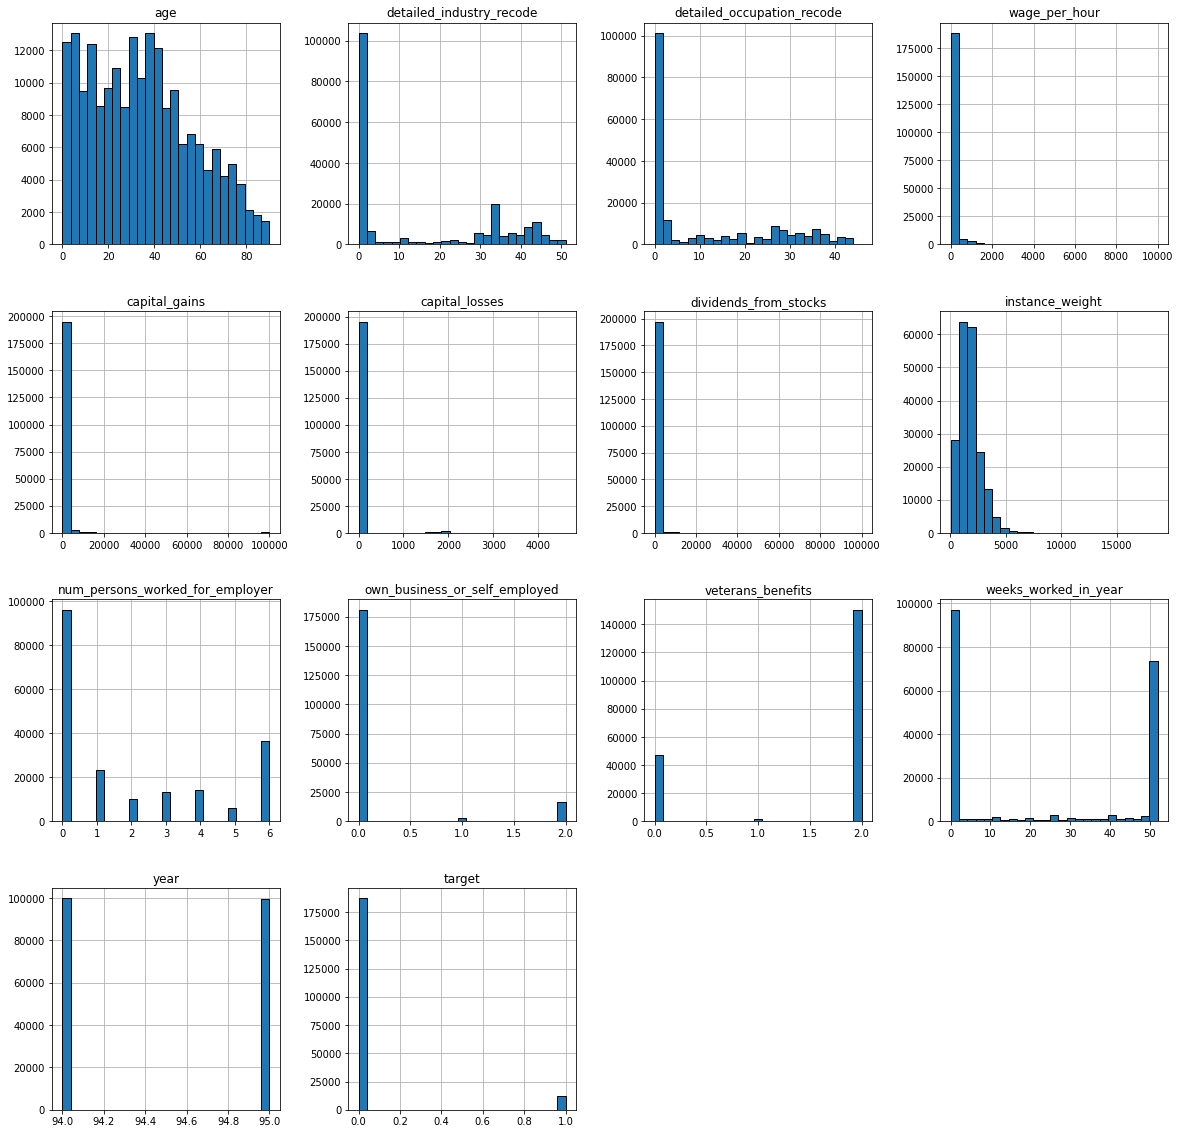

In [65]:
data.hist(bins=25, figsize=(20, 20), edgecolor='black', zorder=2);
plt.grid(zorder=0)

We can see that most of the features have left-skewed distribution: with the peak at the very beginning and a heavy tail.
We will keep this in mind for further preprocessing.

We will explore only one feature in detail: `age`

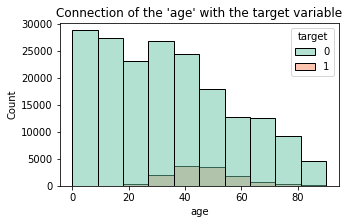

In [66]:
feature='age'
plt.figure(figsize=(5, 3))
sns.histplot(data, x=feature, hue='target', bins= 10, palette="Set2");
plt.title(f"Connection of the '{feature}' with the target variable");

We can see in the picture above that people usually make more money when they are within a period of age from late thirties to middle fifties.

Let us calculate Pearson's correlation for each combination of features and represent it as a correlation matrix.

In [67]:
corr_matrix = data.corr(method='pearson')

In [68]:
corr_matrix

,age,detailed_industry_recode,detailed_occupation_recode,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,instance_weight,num_persons_worked_for_employer,own_business_or_self_employed,veterans_benefits,weeks_worked_in_year,year,target
age,1.000000,0.157822,0.117414,0.036938,0.053590,0.063351,0.104976,-0.001611,0.140887,-0.002265,0.674844,0.206181,0.004413,0.135720
detailed_industry_recode,0.157822,1.000000,0.563493,0.165980,0.066017,0.072586,0.012774,0.029388,0.642096,0.252694,0.476475,0.754472,0.003430,0.196190
detailed_occupation_recode,0.117414,0.563493,1.000000,0.194498,0.002534,0.043680,-0.026726,0.027047,0.515554,0.228952,0.438680,0.655613,-0.003140,0.013414
wage_per_hour,0.036938,0.165980,0.194498,1.000000,-0.001082,0.010993,-0.005731,0.012353,0.191543,0.054051,0.113094,0.195687,0.002283,0.024528
capital_gains,0.053590,0.066017,0.002534,-0.001082,1.000000,-0.012700,0.131476,0.002549,0.058015,0.015048,0.051530,0.083549,0.005243,0.240725
capital_losses,0.063351,0.072586,0.043680,0.010993,-0.012700,1.000000,0.042427,0.008052,0.084255,0.024116,0.075391,0.100762,0.000096,0.147417
dividends_from_stocks,0.104976,0.012774,-0.026726,-0.005731,0.131476,0.042427,1.000000,-0.000009,0.007206,-0.004885,0.054585,0.013823,0.001913,0.175779
instance_weight,-0.001611,0.029388,0.027047,0.012353,0.002549,0.008052,-0.000009,1.000000,0.042778,0.012328,0.040507,0.029240,0.011765,0.014463
num_persons_worked_for_employer,0.140887,0.642096,0.515554,0.191543,0.058015,0.084255,0.007206,0.042778,1.000000,0.240553,0.463334,0.747302,0.018774,0.222684
own_business_or_self_employed,-0.002265,0.252694,0.228952,0.054051,0.015048,0.024116,-0.004885,0.012328,0.240553,1.000000,0.177448,0.265872,0.007377,0.040473


All features have a positive and almost uniformly distributed correlation with the target.

### **PCA for numeric features**

Let us apply Principal component analysis ([PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)) to choose the most important features in a sense of data variance.

In [69]:
def apply_pca(data: pd.DataFrame):
  data_pca = data.drop(columns='target')
  data_pca = data_pca.select_dtypes(exclude='object')
  sc = StandardScaler()
  cols = data_pca.columns
  data_pca = sc.fit_transform(data_pca)
  pca = PCA()
  data_pca = pca.fit_transform(data_pca)
  return pca, data_pca

In [70]:
pca, _ = apply_pca(data)

In [71]:
explained_variance = pca.explained_variance_ratio_
explained_variance, np.cumsum(explained_variance)

(array([0.280509  , 0.10417459, 0.08390991, 0.07777195, 0.076758  ,
        0.07593252, 0.07327461, 0.06670811, 0.06363837, 0.0381337 ,
        0.02697227, 0.01747842, 0.01473855]),
 array([0.280509  , 0.38468359, 0.4685935 , 0.54636545, 0.62312345,
        0.69905597, 0.77233058, 0.8390387 , 0.90267706, 0.94081076,
        0.96778303, 0.98526145, 1.        ]))

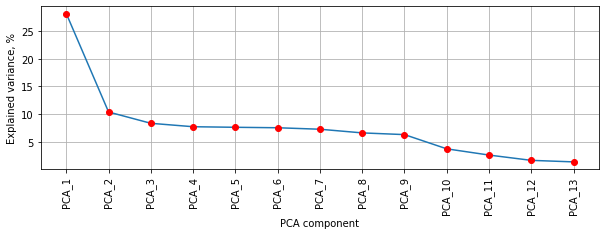

In [72]:
x = range(1, len(explained_variance) + 1)
x_labels = ['PCA_' + str(number) for number in range(1, len(explained_variance) + 1)]
plt.figure(figsize=(10, 3))
plt.plot(x, explained_variance * 100,'o-',  mfc='red', mec='red');

plt.xticks(ticks=range(1, len(explained_variance) + 1), labels=x_labels, rotation=90)
plt.xlabel('PCA component')
plt.ylabel('Explained variance, %')
plt.grid()

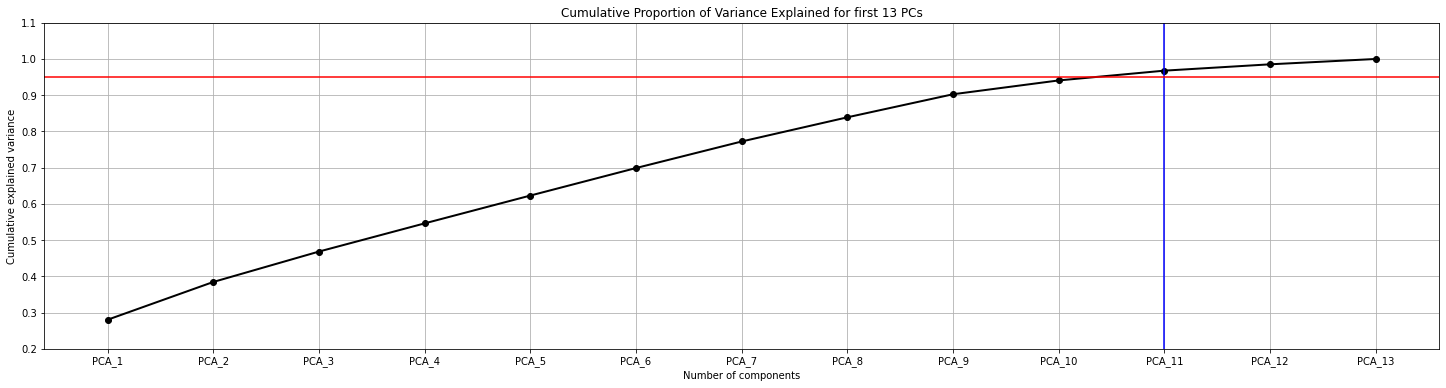

In [73]:
k=13
plt.figure(figsize=(25, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_[:k]), color='k', marker='o', lw=2)

plt.yticks(np.arange(0.2, 1.2, 0.1))
plt.axvline(10, c='b')
plt.axhline(0.95, c='r')

plt.title('Cumulative Proportion of Variance Explained for first {} PCs'.format(k))
plt.xticks(ticks=range(len(explained_variance)), labels=x_labels, rotation=0)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid()

plt.show()

We obtained that 11 PCs contain more than 95% of variance of the initial dataset (for numerical features only).
Frankly speaking I do not know how to use that knowledge for dimensionality reduction: I mean our Principal Components do not have one-to-one correspondence to the features, so it is unclear which raw features to drop.

In [74]:
#Show the total number of features, number of categorical features and numerical ones respectively
data.shape[1], data.select_dtypes(include='object').shape[1], data.select_dtypes(exclude='object').shape[1]

(42, 28, 14)

### **Conclusion for data exploration**

Using EDA we knew our data a little bit better know, but still have quite a large number of features (42 features, including: categorical - 28, numerical - 14).

Let us use common sense to drop some useless features. We can do that since the names of the features tell for themselves.

We may assume that:
- `country_of_birth_father`, `country_of_birth_mother` and `country_of_birth_self` useless for our task: place of origin does not influence income;
- `fill_in_questionnaire_for_veteran_admin` just a flag whether questionnaire filled in or not;
- `family_members_under_18`  does not effect income level (please see DataFrame below);
- `region_of_previous_residence`, `state_of_previous_residence` do not effect income;
- `detailed_household_and_family_stat` detailed version of the feature `detailed_household_summary_in_household`;
- `own_business_or_self_employed`;
- `migration_prev_res_in_sunbelt` it is not a representative feature;
- `live_in_this_house_1_year_ago` seems to be useless for income prediction purposes.

Thus, for the sake of dimensionality reduction we will drop columns mentioned above.

In [75]:
columns_to_drop.extend(['country_of_birth_father',
                        'country_of_birth_mother',
                        'country_of_birth_self',
                        'fill_in_questionnaire_for_veteran_admin',
                        'family_members_under_18',
                        'region_of_previous_residence',
                        'state_of_previous_residence',
                        'detailed_household_and_family_stat',
                        'own_business_or_self_employed',
                        'migration_prev_res_in_sunbelt',
                        'live_in_this_house_1_year_ago'])
columns_to_drop

['instance_weight',
 'year',
 'hispanic_origin',
 'reason_for_unemployment',
 'migration_code-change_in_reg',
 'migration_code-move_within_reg',
 'country_of_birth_father',
 'country_of_birth_mother',
 'country_of_birth_self',
 'fill_in_questionnaire_for_veteran_admin',
 'family_members_under_18',
 'region_of_previous_residence',
 'state_of_previous_residence',
 'detailed_household_and_family_stat',
 'own_business_or_self_employed',
 'migration_prev_res_in_sunbelt',
 'live_in_this_house_1_year_ago']

In [76]:
data.drop(columns=columns_to_drop, inplace=True)

In [77]:
#Show: the total number of features, number of categorical features and numerical ones respectively
data.shape[1], data.select_dtypes(include='object').shape[1], data.select_dtypes(exclude='object').shape[1]

(25, 14, 11)

Missing values

In [78]:
data.columns[data.isna().sum() > 0]

Index(['migration_code-change_in_msa'], dtype='object')

In [79]:
columns_nans = data.columns[data.isna().sum() > 0].to_list()

if columns_nans:
  print('Columns with missing values:')
  print(*columns_nans, sep=', ', end='.\n')
  print(f'\nNumber of mising values:\n{data.isna().sum().loc[columns_nans]}')
  print(f'\nProportion of mising values, %:\n{round(100 * data.isna().mean().loc[columns_nans], 2)}')
else:
  print('There are not columns with missing values in the dataset')

Columns with missing values:
migration_code-change_in_msa.

Number of mising values:
migration_code-change_in_msa    99696
dtype: int64

Proportion of mising values, %:
migration_code-change_in_msa    49.97
dtype: float64


We will substitute those NaNs by `-1` this is because the number of missing values in that feature is relatively high.

In [80]:
data['migration_code-change_in_msa'].fillna(-1, inplace=True)

2.2 Categorical features encoding

Choose categorical features

In [81]:
data.select_dtypes(include='object').columns

Index(['class_of_worker', 'education', 'enroll_in_edu_inst_last_wk',
       'marital_stat', 'major_industry_code', 'major_occupation_code', 'race',
       'sex', 'member_of_a_labor_union', 'full_or_part_time_employment_stat',
       'tax_filer_stat', 'detailed_household_summary_in_household',
       'migration_code-change_in_msa', 'citizenship'],
      dtype='object')

Let us encode them one-by-one.

`class_of_worker`: frequency encoding

In [82]:
class_of_worker_map = data['class_of_worker'].value_counts()
map['class_of_worker'] = class_of_worker_map

In [83]:
data['class_of_worker'] = data['class_of_worker'].map(class_of_worker_map)

`education` is an example of an ordinal feature. Sure, we can define an order on it. For instance, `High school graduate` has higher rank than `12th grade no diploma`, and `Doctorate degree(PhD EdD)` has higher rank than `Some college but no degree`. We can encode this feature with integer numbers in a correct order.

In [84]:
data['education'].unique(), len(data['education'].unique())

(array([' High school graduate', ' Some college but no degree',
        ' 10th grade', ' Children', ' Bachelors degree(BA AB BS)',
        ' Masters degree(MA MS MEng MEd MSW MBA)', ' Less than 1st grade',
        ' Associates degree-academic program', ' 7th and 8th grade',
        ' 12th grade no diploma', ' Associates degree-occup /vocational',
        ' Prof school degree (MD DDS DVM LLB JD)', ' 5th or 6th grade',
        ' 11th grade', ' Doctorate degree(PhD EdD)', ' 9th grade',
        ' 1st 2nd 3rd or 4th grade'], dtype=object),
 17)

In [85]:
education_map = {
    ' Children': 0,
    ' Less than 1st grade': 1,
    ' 1st 2nd 3rd or 4th grade': 2,
    ' 5th or 6th grade': 3,
    ' 7th and 8th grade': 4,
    ' 9th grade': 5,
    ' 10th grade': 6,
    ' 11th grade': 7,
    ' 12th grade no diploma': 8,
    ' High school graduate': 9,
    ' Some college but no degree': 10,
    ' Associates degree-occup /vocational': 11,
    ' Associates degree-academic program': 12,
    ' Bachelors degree(BA AB BS)': 13,
    ' Masters degree(MA MS MEng MEd MSW MBA)': 14,
    ' Prof school degree (MD DDS DVM LLB JD)': 15,
    ' Doctorate degree(PhD EdD)': 16
}
map['education'] = education_map

In [86]:
data['education'] = data['education'].map(education_map)

In [87]:
data['education'].unique(), len(data['education'].unique())

(array([ 9, 10,  6,  0, 13, 14,  1, 12,  4,  8, 11, 15,  3,  7, 16,  5,  2],
       dtype=int64),
 17)

`enroll_in_edu_inst_last_wk`

In [88]:
data['enroll_in_edu_inst_last_wk'].unique(), len(data['enroll_in_edu_inst_last_wk'].unique())

(array([' Not in universe', ' High school', ' College or university'],
       dtype=object),
 3)

Let us again apply mapping for ordinal feature.

In [89]:
enroll_in_edu_inst_last_wk_map = {
    ' Not in universe': 0,
    ' High school': 1,
    ' College or university': 2
}
map['enroll_in_edu_inst_last_wk'] = enroll_in_edu_inst_last_wk_map

In [90]:
data['enroll_in_edu_inst_last_wk'] = data['enroll_in_edu_inst_last_wk'].map(enroll_in_edu_inst_last_wk_map)

In [91]:
data['enroll_in_edu_inst_last_wk'].unique(), len(data['enroll_in_edu_inst_last_wk'].unique())

(array([0, 1, 2], dtype=int64), 3)

`marital_stat`

In [92]:
data['marital_stat'].unique(), len(data['marital_stat'].unique())

(array([' Widowed', ' Divorced', ' Never married',
        ' Married-civilian spouse present', ' Separated',
        ' Married-spouse absent', ' Married-A F spouse present'],
       dtype=object),
 7)

`marital_stat` is an example of a nominal feature. We will use One-Hot encoding to encode it, applying  `get_dummies` function from pandas.

In [93]:
df_marital_stat = pd.get_dummies(data['marital_stat'], prefix='marital_stat', prefix_sep='_')
data = pd.concat([data, df_marital_stat], axis=1)
data.drop(labels='marital_stat', axis=1, inplace=True)

In [94]:
# explore the result of OHE
data[[x for x in data.columns if x.startswith('marital_stat')]]

,marital_stat_ Divorced,marital_stat_ Married-A F spouse present,marital_stat_ Married-civilian spouse present,marital_stat_ Married-spouse absent,marital_stat_ Never married,marital_stat_ Separated,marital_stat_ Widowed
0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
199518,0,0,1,0,0,0,0
199519,0,0,1,0,0,0,0
199520,0,0,1,0,0,0,0
199521,0,0,0,0,1,0,0


`major_industry_code`

In [95]:
data['major_industry_code'].unique(), len(data['major_industry_code'].unique())

(array([' Not in universe or children', ' Construction', ' Entertainment',
        ' Finance insurance and real estate', ' Education',
        ' Business and repair services', ' Manufacturing-nondurable goods',
        ' Personal services except private HH',
        ' Manufacturing-durable goods', ' Other professional services',
        ' Mining', ' Transportation', ' Wholesale trade',
        ' Public administration', ' Retail trade', ' Social services',
        ' Private household services', ' Utilities and sanitary services',
        ' Communications', ' Hospital services',
        ' Medical except hospital', ' Agriculture',
        ' Forestry and fisheries', ' Armed Forces'], dtype=object),
 24)

Encode feature `major_industry_code` using frequency encoding, since there are a lot of unique values, and using e.g. OHE will lead to dimensionality increasing.

In [96]:
major_industry_code_map = data['major_industry_code'].value_counts()
map['major_industry_code'] = major_industry_code_map

In [97]:
data['major_industry_code'] = data['major_industry_code'].map(major_industry_code_map)

In [98]:
data['major_industry_code'].unique(), len(data['major_industry_code'].unique())

(array([100684,   5984,   1651,   6145,   8283,   5651,   6897,   2937,
          9015,   4482,    563,   4209,   3596,   4610,  17070,   2549,
           945,   1178,   1181,   3964,   4683,   3023,    187,     36],
       dtype=int64),
 24)

`major_occupation_code` frequency encoding

In [99]:
data['major_occupation_code'].unique(), len(data['major_occupation_code'].unique()), data['major_occupation_code'].isna().sum()

(array([' Not in universe', ' Precision production craft & repair',
        ' Professional specialty', ' Executive admin and managerial',
        ' Handlers equip cleaners etc ', ' Adm support including clerical',
        ' Machine operators assmblrs & inspctrs', ' Other service',
        ' Sales', ' Private household services',
        ' Technicians and related support',
        ' Transportation and material moving',
        ' Farming forestry and fishing', ' Protective services',
        ' Armed Forces'], dtype=object),
 15,
 0)

In [100]:
major_occupation_code_map = data['major_occupation_code'].value_counts()
map['major_occupation_code'] = major_occupation_code_map

In [101]:
data['major_occupation_code'] = data['major_occupation_code'].map(major_occupation_code_map)

In [102]:
data['major_occupation_code'].unique(), len(data['major_occupation_code'].unique()), data['major_occupation_code'].isna().sum()

(array([100684,  10518,  13940,  12495,   4127,  14837,   6379,  12099,
         11783,    780,   3018,   4020,   3146,   1661,     36],
       dtype=int64),
 15,
 0)

`race`: OHE

In [103]:
data['race'].unique(), len(data['race'].unique()), data['race'].isna().sum()

(array([' White', ' Asian or Pacific Islander',
        ' Amer Indian Aleut or Eskimo', ' Black', ' Other'], dtype=object),
 5,
 0)

In [104]:
df_race = pd.get_dummies(data['race'], prefix='race', prefix_sep='_')
data = pd.concat([data, df_race], axis=1)
data.drop(labels='race', axis=1, inplace=True)

`sex` is an example of a binary feature. Let us double check that it has no missing values, which makes its encoding pretty easy.

In [105]:
data['sex'].unique(), len(data['sex'].unique()), data['sex'].isna().sum()

(array([' Female', ' Male'], dtype=object), 2, 0)

In [106]:
sex_map = {
    ' Female': 0,
    ' Male': 1
}
map['sex'] = sex_map

In [107]:
data['sex'] = data['sex'].map(sex_map)

In [108]:
data['sex'].unique(), len(data['sex'].unique()), data['sex'].isna().sum()

(array([0, 1], dtype=int64), 2, 0)

`member_of_a_labor_union`

In [109]:
data['member_of_a_labor_union'].unique(), len(data['member_of_a_labor_union'].unique()), data['member_of_a_labor_union'].isna().sum()

(array([' Not in universe', ' No', ' Yes'], dtype=object), 3, 0)

In [110]:
member_of_a_labor_union_map = {
    ' Not in universe': -1,
    ' No': 0,
    ' Yes': 1
}
map['member_of_a_labor_union'] = member_of_a_labor_union_map

In [111]:
data['member_of_a_labor_union'] = data['member_of_a_labor_union'].map(member_of_a_labor_union_map)

In [112]:
data['member_of_a_labor_union'].unique(), len(data['member_of_a_labor_union'].unique()), data['member_of_a_labor_union'].isna().sum()

(array([-1,  0,  1], dtype=int64), 3, 0)

`full_or_part_time_employment_stat` frequency encoding

In [113]:
data['full_or_part_time_employment_stat'].unique(), len(data['full_or_part_time_employment_stat'].unique()), data['full_or_part_time_employment_stat'].isna().sum()

(array([' Not in labor force', ' Children or Armed Forces',
        ' Full-time schedules', ' Unemployed full-time',
        ' Unemployed part- time', ' PT for non-econ reasons usually FT',
        ' PT for econ reasons usually PT',
        ' PT for econ reasons usually FT'], dtype=object),
 8,
 0)

In [114]:
full_or_part_time_employment_stat_map = data['full_or_part_time_employment_stat'].value_counts()
map['full_or_part_time_employment_stat'] = full_or_part_time_employment_stat_map

In [115]:
data['full_or_part_time_employment_stat'] = data['full_or_part_time_employment_stat'].map(full_or_part_time_employment_stat_map)

`tax_filer_stat` let us apply CatBoostEncoder to try target based encoding technique.

In [116]:
feature = 'tax_filer_stat'
data[feature].unique(), len(data[feature].unique()), data[feature].isna().sum()

(array([' Nonfiler', ' Head of household', ' Joint both under 65',
        ' Single', ' Joint both 65+', ' Joint one under 65 & one 65+'],
       dtype=object),
 6,
 0)

In [117]:
!pip install category_encoders

Defaulting to user installation because normal site-packages is not writeable


In [118]:
from category_encoders.cat_boost import CatBoostEncoder
# your code here
display('Before', data[feature])
tax_filer_stat_encoder = CatBoostEncoder(handle_missing='return_nan').fit(X=data[feature], y=data['target'])
data[feature] = tax_filer_stat_encoder.transform(data[feature], data['target'])
display('After', data[feature])

'Before'

0                              Nonfiler
1                     Head of household
2                              Nonfiler
3                              Nonfiler
4                              Nonfiler
                      ...              
199518                   Joint both 65+
199519     Joint one under 65 & one 65+
199520              Joint both under 65
199521                         Nonfiler
199522                           Single
Name: tax_filer_stat, Length: 199523, dtype: object

'After'

0         0.062058
1         0.062058
2         0.031029
3         0.020686
4         0.015515
            ...   
199518    0.054016
199519    0.077854
199520    0.131384
199521    0.000467
199522    0.061331
Name: tax_filer_stat, Length: 199523, dtype: float64

Let us again apply mapping for ordinal feature: `detailed_household_summary_in_household`

In [119]:
feature = 'detailed_household_summary_in_household'
data[feature].unique(), len(data[feature].unique()), data[feature].isna().sum()

(array([' Other relative of householder', ' Householder',
        ' Child 18 or older', ' Child under 18 never married',
        ' Spouse of householder', ' Nonrelative of householder',
        ' Group Quarters- Secondary individual',
        ' Child under 18 ever married'], dtype=object),
 8,
 0)

In [120]:
detailed_household_summary_in_household_map = {
    ' Group Quarters- Secondary individual': 0,
    ' Nonrelative of householder': 1,
    ' Other relative of householder': 2,
    ' Child under 18 never married': 3,
    ' Child under 18 ever married': 4,
    ' Child 18 or older': 5,
    ' Spouse of householder': 6,
    ' Householder': 7
}
map[feature] = detailed_household_summary_in_household_map

In [121]:
data[feature] = data[feature].map(detailed_household_summary_in_household_map)

In [122]:
data[feature].unique(), len(data[feature].unique()), data[feature].isna().sum()

(array([2, 7, 5, 3, 6, 1, 0, 4], dtype=int64), 8, 0)

In [123]:
feature = 'migration_code-change_in_msa'
data[feature].unique(), len(data[feature].unique()), data[feature].isna().sum()

(array([-1, 'Other', 'Nonmover', 'Not in universe', 'Abroad'], dtype=object),
 5,
 0)

In [124]:
display('Before', data[feature])
migration_code_encoder = CatBoostEncoder(handle_missing='return_nan').fit(X=data[feature], y=data['target'])
data[feature] = migration_code_encoder.transform(data[feature], data['target'])
display('After', data[feature])

'Before'

0               -1
1            Other
2               -1
3         Nonmover
4         Nonmover
            ...   
199518          -1
199519    Nonmover
199520          -1
199521          -1
199522    Nonmover
Name: migration_code-change_in_msa, Length: 199523, dtype: object

'After'

0         0.062058
1         0.062058
2         0.031029
3         0.062058
4         0.031029
            ...   
199518    0.065631
199519    0.063257
199520    0.065631
199521    0.065630
199522    0.063256
Name: migration_code-change_in_msa, Length: 199523, dtype: float64

`citizenship` frequency encoding

In [125]:
feature = 'citizenship'
data[feature].unique(), len(data[feature].unique()), data[feature].isna().sum()

(array([' Native- Born in the United States',
        ' Foreign born- Not a citizen of U S ',
        ' Foreign born- U S citizen by naturalization',
        ' Native- Born abroad of American Parent(s)',
        ' Native- Born in Puerto Rico or U S Outlying'], dtype=object),
 5,
 0)

In [126]:
citizenship_map = data[feature].value_counts()
map[feature] = citizenship_map

In [127]:
data[feature] = data[feature].map(citizenship_map)

In [128]:
data[feature].unique(), len(data[feature].unique()), data[feature].isna().sum()

(array([176992,  13401,   5855,   1756,   1519], dtype=int64), 5, 0)

So, we have encoded all the categorical features.

### Clustering based on `MDS_AML_Webinar_clusterisation_August`

In [129]:
_, data_pca = apply_pca(data)

In [130]:
X_two_dim = data_pca[:, :2]
idx = (X_two_dim[:,0] < 50) & (X_two_dim[:,1] < 15)
X_two_dim = X_two_dim[idx,:]

In [131]:
# number of clusters equal 2, since we solve a binary classification and
# know in advance that data can be perfectly split into two groups
# (low or high income)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_two_dim)

KMeans(n_clusters=2)

Add number of cluster to the data dataframe.

In [132]:
data['cluster'] = kmeans.labels_

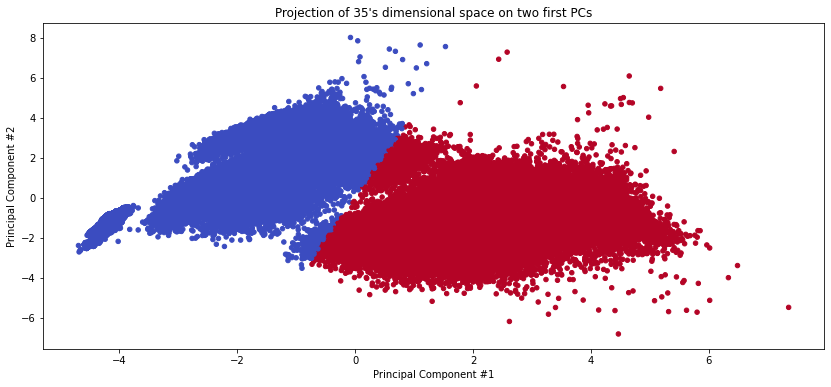

In [133]:
plt.figure(figsize=(14, 6))

plt.scatter(X_two_dim[:,0], X_two_dim[:,1], c=kmeans.labels_, s=20, cmap='coolwarm');

plt.title('Projection of 35\'s dimensional space on two first PCs')
plt.xlabel('Principal Component #1')
plt.ylabel('Principal Component #2')

plt.show()

In [134]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.family'] = 'DejaVu Sans'


def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)


def plot_centroids(centroids, weights=None, circle_color='w', cross_color='g'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)


def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Filled Colors
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    # Contour line
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)


def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    # Calculate -log densities
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),   # normalize using log normal
                 levels=np.logspace(0, 2, 12))        # 12 levels
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])   # get cluster
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

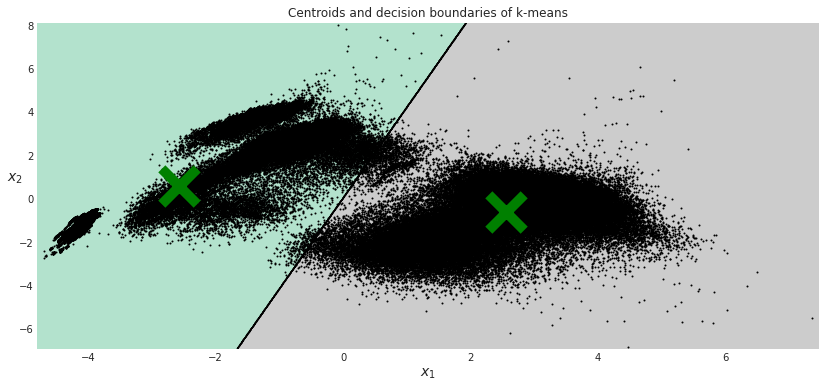

In [135]:
plt.figure(figsize=(14, 6))
plot_decision_boundaries(kmeans, X_two_dim)

plt.title('Centroids and decision boundaries of k-means')

plt.show()

After all changes we get.

In [136]:
data.head()

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,major_industry_code,major_occupation_code,sex,...,marital_stat_ Married-spouse absent,marital_stat_ Never married,marital_stat_ Separated,marital_stat_ Widowed,race_ Amer Indian Aleut or Eskimo,race_ Asian or Pacific Islander,race_ Black,race_ Other,race_ White,cluster
0,73,100245,0,0,9,0,0,100684,100684,0,...,0,0,0,1,0,0,0,0,1,0
1,58,8445,4,34,10,0,0,5984,10518,1,...,0,0,0,0,0,0,0,0,1,1
2,18,100245,0,0,6,0,1,100684,100684,0,...,0,1,0,0,0,1,0,0,0,0
3,9,100245,0,0,0,0,0,100684,100684,0,...,0,1,0,0,0,0,0,0,1,0
4,10,100245,0,0,0,0,0,100684,100684,0,...,0,1,0,0,0,0,0,0,1,0


In [137]:
data[['cluster', 'target']]

,cluster,target
0,0,0
1,1,0
2,0,0
3,0,0
4,0,0
...,...,...
199518,0,0
199519,1,0
199520,1,0
199521,0,0


Proportion of classes in 'cluster', %:
1    50.1
0    49.9
Name: cluster, dtype: float64


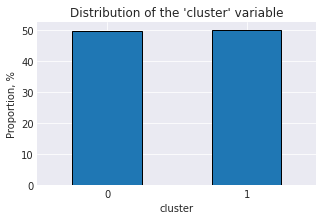

In [138]:
print(draw_plot(data.cluster))

Proportion of classes in 'target', %:
0    93.8
1     6.2
Name: target, dtype: float64


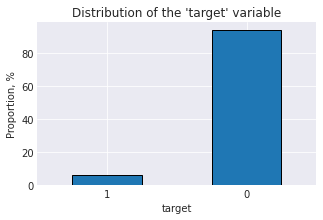

In [139]:
print(draw_plot(data.target))

All of a sudden, distribution of the `cluster` variable is uniform, this is ridiculous! We definitely will not use that feature for the training purposes. Unfortunately I do not know how to solve this problem and have to drop this feature.

## 3. Model training

### Train/validation split

We will split the dataset into two part: training (80%) and validation (20%).
Validation part will be used for the fine-tuning the models.

In [140]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['cluster', 'target'])
y = data['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Different techniques which can help to work with imbalanced data

Based on `Programming assignment for week 4`.

There are two main techniques: undersampling and oversampling.
Let us try to apply them.

In [141]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, RandomOverSampler, SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler, TomekLinks
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, matthews_corrcoef, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

### Undersamplig

In [142]:
rus = RandomUnderSampler(random_state=13)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

Before applying undersampling
Shape of X (159618, 34) and y (159618,)
Proportion of classes in 'target', %:
0    93.8
1     6.2
Name: target, dtype: float64


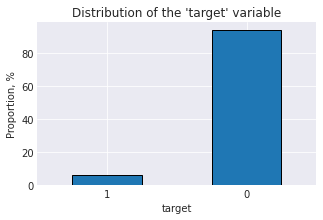

In [143]:
print('Before applying undersampling')
print(f'Shape of X {X_train.shape} and y {y_train.shape}')
print(draw_plot(y_train))

After applying undersampling
Shape of X (19812, 34) and y (19812,)
Proportion of classes in 'target', %:
0    50.0
1    50.0
Name: target, dtype: float64


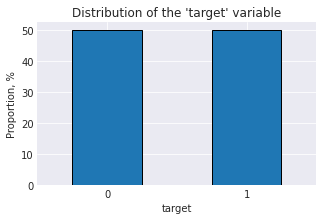

In [144]:
print('After applying undersampling')
print(f'Shape of X {X_train_rus.shape} and y {y_train_rus.shape}')
print(draw_plot(y_train_rus))

We can see that the size of the dataset dicreases drastically, but target variable has a uniform distribution of classes.

### Oversampling

In [145]:
ros = RandomOverSampler(sampling_strategy=0.8, random_state=13)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

Before applying oversampling
Shape of X (159618, 34) and y (159618,)
Proportion of classes in 'target', %:
0    93.8
1     6.2
Name: target, dtype: float64


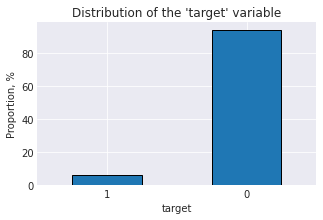

In [146]:
print('Before applying oversampling')
print(f'Shape of X {X_train.shape} and y {y_train.shape}')
print(draw_plot(y_train))

After applying oversampling
Shape of X (269481, 34) and y (269481,)
Proportion of classes in 'target', %:
0    55.6
1    44.4
Name: target, dtype: float64


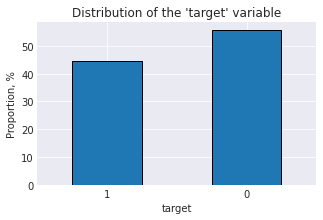

In [147]:
print('After applying oversampling')
print(f'Shape of X {X_train_ros.shape} and y {y_train_ros.shape}')
print(draw_plot(y_train_ros))

The size of the dataset has increased significantly and target variable does not have such an extreme difference between classes as it was before.

Undersampling and oversampling quite a good techniques to tackle the problem of imbalanced data, but as we saw they led to dataset size changes. We will not use these techniques in our project since they alter the class distribution of the training data (to avoid additional bias).

### Train different machine learning models

In [148]:
def compute_metrics(y_test, y_pred):
    print('Accuracy: {:.5f}'.format(accuracy_score(y_test, y_pred)))
    print('F-score: {:.5f}'.format(f1_score(y_test, y_pred)))
    print('Precision: {:.5f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.5f}'.format(recall_score(y_test, y_pred)))
    print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_test, y_pred)))
    print('MCC: {:.5f}'.format(matthews_corrcoef(y_test, y_pred)))

def compute_confusion_matrix(y_test, y_pred):
    compute_metrics(y_test, y_pred)
    return pd.DataFrame(
        confusion_matrix(y_test, y_pred, labels=[1, 0]),
        columns=['a(x) = 1', 'a(x) = 0'],
        index=['y = 1', 'y = 0'],
    ).T

In [149]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [150]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

Model 1: `Support vector machine`

In [151]:
from sklearn.svm import SVC

In [152]:
svm_pipe = Pipeline([('classifier', SVC(kernel='linear'))])
params1 = {
    'classifier__C': [0.1, 1],
    'classifier__kernel': ['linear', 'poly']
}

grid_svm_pipe = GridSearchCV(svm_pipe,
                             param_grid=params1,
                             cv=3, scoring='f1')

Fine-tuning

In [ ]:
grid_svm_pipe.fit(X_train, y_train);

In [ ]:
grid_svm_pipe.best_estimator_.fit(X_train, y_train)
y_pred_svm = grid_svm_pipe.best_estimator_.predict(X_val)

In [ ]:
compute_confusion_matrix(y_val, y_pred_svm)

Model 2: `Randomforest classifier`

In [ ]:
rfc_pipe = Pipeline([
    ('classifier', RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced'))
])

Fine-tuning

In [ ]:
params = {
    'classifier__max_depth' : [4, 5],
    'classifier__criterion' :['gini', 'entropy']
}

grid_rfc_pipe = GridSearchCV(rfc_pipe,
                             param_grid=params,
                             cv=3,
                             scoring='f1')

In [ ]:
# Fitting
grid_rfc_pipe.fit(X_train, y_train);

In [ ]:
# Best parameters
grid_rfc_pipe.best_params_

In [ ]:
# predictions for RFC with Best parameters found during Grid Search with CV
grid_rfc_pipe.best_estimator_.fit(X_train, y_train)
y_pred_rfc = grid_rfc_pipe.best_estimator_.predict(X_val)

In [ ]:
compute_confusion_matrix(y_val, y_pred_rfc)

Model 3: `XGBoost`

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_pipe = Pipeline([
    ('classifier', XGBClassifier(objective='reg:squarederror', n_estimators=200, learning_rate=0.01, max_depth=5, random_state=13))
])

In [ ]:
params2 = {
    'classifier__max_depth' : [4, 5],
    'classifier__sampling_method' :['uniform', 'gradient_based']
}

grid_xgb_pipe = GridSearchCV(xgb_pipe,
                             param_grid=params2,
                             cv=3,
                             scoring='f1')

In [ ]:
grid_xgb_pipe.fit(X_train, y_train)

In [ ]:
grid_xgb_pipe.best_estimator_.fit(X_train, y_train)
y_pred_xgb = grid_xgb_pipe.best_estimator_.predict(X_val)

In [ ]:
compute_confusion_matrix(y_val, y_pred_xgb)

Due to lack of computational resources blending (and its tuning) will be performed on test dataset.

### Download and preprocess test dataset

In [ ]:
test_data = pd.read_csv(path_common + 'census-income.test', names=features, na_values=' ?')

In [ ]:
test_data.head()

In [ ]:
test_data.info()

In [ ]:
test_data.describe(include=['O'])

In [ ]:
# Let us explore target variable distribution
print(draw_plot(test_data['target']))

In [ ]:
test_data.drop(columns=columns_to_drop, inplace=True)

In [ ]:
map['migration_code-change_in_msa'][np.nan] = np.nan
map['migration_code-change_in_msa']

Test dataset encoding

In [ ]:
for mapping in map.keys():
  test_data[mapping] = test_data[mapping].map(map[mapping])

In [ ]:
test_data['migration_code-change_in_msa'].fillna(-1, inplace=True)

In [ ]:
feature = 'migration_code-change_in_msa'
migration_code_encoder = CatBoostEncoder(handle_missing='return_nan').fit(X=test_data[feature], y=test_data['target'])
test_data[feature] = migration_code_encoder.transform(test_data[feature], test_data['target'])

In [ ]:
df_marital_stat = pd.get_dummies(test_data['marital_stat'], prefix='marital_stat', prefix_sep='_')
test_data = pd.concat([test_data, df_marital_stat], axis=1)
test_data.drop(labels='marital_stat', axis=1, inplace=True)

In [ ]:
df_race = pd.get_dummies(test_data['race'], prefix='race', prefix_sep='_')
test_data = pd.concat([test_data, df_race], axis=1)
test_data.drop(labels='race', axis=1, inplace=True)

In [ ]:
feature = 'tax_filer_stat'
tax_filer_stat_encoder = CatBoostEncoder(handle_missing='return_nan').fit(X=test_data[feature], y=test_data['target'])
test_data[feature] = tax_filer_stat_encoder.transform(test_data[feature], test_data['target'])

In [ ]:
# all columns are numeric after encoding
test_data.info()

## 4. Summary


### Prediction on test

In [ ]:
X_test_data = test_data.drop(columns=['target'])
y_test_data = test_data['target']

`SVC`

In [ ]:
y_pred_svm = grid_svm_pipe.best_estimator_.predict(X_test_data)

In [ ]:
compute_confusion_matrix(y_test_data, y_pred_svm)

`Randomforest classifier`

In [ ]:
y_pred_rfc = grid_rfc_pipe.best_estimator_.predict(X_test_data)

In [ ]:
compute_confusion_matrix(y_test_data, y_pred_rfc)

`XGBoost`

In [ ]:
y_pred_xgb = grid_xgb_pipe.best_estimator_.predict(X_test_data)

In [ ]:
compute_confusion_matrix(y_test_data, y_pred_xgb)

### Blending

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
X_test_blend = pd.concat([pd.Series(y_pred_svm, name='svm'),
                         pd.Series(y_pred_rfc, name='rfc'),
                        pd.Series(y_pred_xgb, name='xgb')
                        ], axis=1)

In [ ]:
weights = np.linspace(0, 1, 101)

Blending: tuning weights

In [ ]:
from tqdm.notebook import tqdm

results = {}
for weight1 in tqdm(weights):
    for weight2 in weights:
        for weight3 in weights:
          combination = [weight1, weight2, weight3]
          if sum(combination) == 1:
            X_test_blend['ensemble'] = weight1 * X_test_blend.svm +  weight2 * X_test_blend.rfc +  weight3 * X_test_blend.xgb
            rmse = mean_squared_error(y_test_data, X_test_blend['ensemble'], squared=False)
            results[rmse] = combination

In [ ]:
best_weights = results[min(results.keys())]

In [ ]:
X_test_blend['ensemble'] = (best_weights[0] * X_test_blend.svm +
                           best_weights[1] * X_test_blend.rfc +
                           best_weights[2] * X_test_blend.xgb)

### Conclusion

Best model (the highest f1-score): XGBoost.
Fine-tuning for Blending helped us to get better results.
All in all, the f1-score is not as we expected it to be in the part 1 of the project. Probably more thorough data preprocessing needs to be done.